In [14]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    span = omega[ -1 ] - omega[ 0 ]
    delta = span / ( n - 1 )

    # A's diagonals 
    diags = [
        30 * np.ones( (n,) ),
        -16 * np.ones( (n - 1,) ),  
        np.ones( (n - 2,) ) 
    ]

    A = np.diag( diags[ 0 ], 0 ) \
        + np.diag( diags[ 1 ], -1 ) \
        + np.diag( diags[ 1 ], 1 ) \
        + np.diag( diags[ 2 ], -2 ) \
        + np.diag( diags[ 2 ], 2 )
    
    A /= (12 * delta**2) 

    x = np.linspace( omega[ 0 ], omega[ -1 ], n )
    b = f( x )

    # boundary conditions
    A[ 0, : ] = 0
    A[ :, 0 ] = 0
    A[ 0, 0 ] = 1
    b[ 0 ] = bc[ 0 ]

    A[ -1, : ] = 0
    A[ :, -1 ] = 0
    A[ -1, -1 ] = 1
    b[ -1 ] = bc[ -1 ] 
    return (A, b)

Call the function using:

In [8]:
omega = [ 0, np.pi ]
f = lambda x : np.sin( x )
n = 100
bc = [ 0, 0 ]
A, b = finDif( omega, f, n, bc )

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [10]:
def LU(A, tol=1e-15):
  A = A.copy()
  size = len( A )

  for k in range(size - 1):
    pivot = A[ k, k ]
    if abs(pivot) < tol:
      raise RuntimeError("Null pivot")

    for j in range( k + 1, size ): 
      A[ j, k ] /= pivot 

    for j in range( k + 1, size ):
      A[ k + 1 : size, j ] -= A[ k + 1 : size, k ] * A[ k, j ] 

    L = np.tril( A )
    for idx in range( size ):
        L[ idx, idx ] = 1.0

  U = np.triu( A )
  return (L, U)


(L, U) = LU( A )

In [16]:
def cholesky(A):
    A = A.copy()
    size = len( A )
    
    for k in range( size - 1 ):
        A[ k, k ] = np.sqrt(A[ k, k ])

        A[ k + 1 : size, k ] = A[ k + 1 : size, k ] / A[ k, k ]

        for j in range(k+1,size):
            A[ j : size, j ] = A[ j : size, j ] - A[ j : size, k ] * A[ j, k ]
    
    A[ -1, -1 ] = np.sqrt(A[ -1, -1 ])

    L = np.tril( A )
    Lt = L.transpose()
    return (L, Lt)


(Ht, H) = cholesky( A )

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [12]:
def L_solve(L, rhs):
    size = len( L )
    x = np.zeros( size )

    x[ 0 ] = rhs[ 0 ] / L[ 0, 0 ]

    for i in range( 1, size ):
        x[ i ] = ( rhs[ i ] - np.dot( L[ i, 0 : i ], x[ 0 : i ] ) ) / L[ i, i ]
    return x

In [13]:
def U_solve(U, rhs):
    size = len( U )
    x = np.zeros( size )

    x[ -1 ] = rhs[ -1 ] / L[ -1, -1 ]

    for i in reversed( range( size - 1 ) ):
        x[ i ] = ( rhs[ i ] - np.dot( U[ i, i + 1 : size ], x[ i + 1 : size ] ) ) / U[ i, i ]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

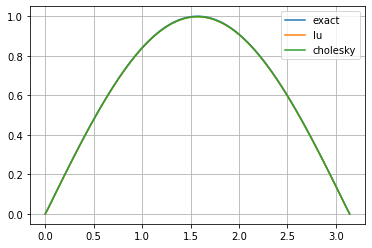

In [18]:
# exact solution 
x = np.linspace( omega[0], omega[-1], n )
u_exact = np.sin( x )

plt.plot( x, u_exact, label = 'exact' )


# using LU factorization
w = L_solve( L, b )
u = U_solve( U, w )

plt.plot( x, u, label = 'lu' )


# using cholesky factorizations 
w = L_solve( Ht, b )
u = U_solve( H, w )

plt.plot( x, u, label = 'cholesky' )

plt.legend()
plt.grid()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [20]:
def compute_errors(omega, f, fex, bc, npoints):
    errors = []

    for idx in range( len(npoints) ):
        npts = npoints[ idx ]
        
        x = np.linspace( omega[0], omega[1], npts )
        ex = fex( x )

        ( A, b ) = finDif( omega, f, npts, bc )
        ( L, U ) = LU( A )
        w = L_solve( L, b )
        u = U_solve( U, w )

        err = sum( ( ex - u )**2 )**0.5
        errors.append( err )
    return errors    

In [25]:
def produce_data(nmin, nmax, step):
  omega = [ 0, 1 ]

  def function(x): 
    y = x * (1 - x)
    return y

  def fexact(x): 
      y = x**4/12 - x**3/6 + x/12
      return y

  bc = [ 0, 0 ]

  npoints = np.arange( nmin, nmax + step, step )
  errors = compute_errors( omega, function, fexact, bc, npoints )
  return (npoints, errors)  

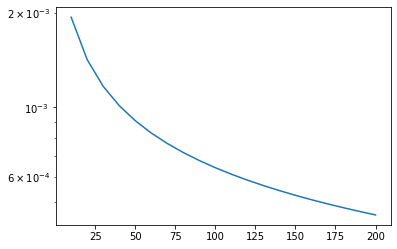

In [32]:
(npoints, errors) = produce_data( 10, 200, 10 )

plt.semilogy( npoints, errors )

In [35]:
(npoints, errors) = produce_data( 10, 200, 10 )

print("#points\t\terror")
for (n, e) in zip(npoints, errors):
  print(f"{n}\t\t{e:.3e}")

#points		error
10		1.936e-03
20		1.419e-03
30		1.167e-03
40		1.013e-03
50		9.078e-04
60		8.294e-04
70		7.683e-04
80		7.190e-04
90		6.781e-04
100		6.434e-04
110		6.136e-04
120		5.876e-04
130		5.646e-04
140		5.441e-04
150		5.257e-04
160		5.091e-04
170		4.939e-04
180		4.800e-04
190		4.672e-04
200		4.554e-04


Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [68]:
def power_method(A, z0, tol=1e-12, nmax=10000):
    q = z0 / np.linalg.norm( z0, 2 )

    it = 0
    err = tol + 1
    
    while it < nmax and err > tol:
        z = A.dot( q )
        l = q.T.dot( z )
        err = np.linalg.norm( z - l*q, 2 )
        q = z / np.linalg.norm( z, 2 )
        it = it + 1
    return (l, q)

def inverse_power_method(A, x0, mu, eps=1.0e-12, nmax=10000):
    M = A - mu * np.eye(len(A))

    (L, U) = LU( M )
    q = x0 / np.linalg.norm( x0, 2 )
    
    err = eps + 1.0
    it = 0
    while err > eps and it < nmax:
        y = L_solve( L, q )
        x = U_solve( U, y )
        q = x / np.linalg.norm( x, 2 )
        z = A.dot( q )
        l = q.T.dot( z )
        err = np.linalg.norm( z - l*q, 2 )
        it = it + 1
    return (l, q)


def condNumb(A):
    z0 = np.ones( ( len(A), ))
    lmax = power_method( A, z0 )[ 0 ]
    lmin = inverse_power_method( A, z0, 0.0 )[ 0 ]

    condNum = lmax / lmin
    return condNum

In [69]:
condNum = condNumb( A )
print(f"A's condition number: {condNum}")

A's condition number: 5289.611999528572


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [51]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10, its_errmax=None):
    x = np.zeros_like( b )
    r = b - A.dot( x )

    rho0 = 1 
    p0 = np.zeros_like( b )

    err = eps + 1.0
    
    it = 1
    while it < nmax and err > eps:
        z = np.linalg.solve( P, r )
        rho = r.dot( z )

        if it > 1:
            beta = rho / rho0 
            p = z + beta * p0
        
        else:
            p = z

        q = A.dot( p )
        alpha = rho / p.dot( q )

        x += p * alpha
        r -= q * alpha
        
        p0 = p
        rho0 = rho

        err = np.linalg.norm( r, 2 )
        it = it + 1
    
    if not its_errmax is None: 
      its_errmax[ 0 ] = it
      its_errmax[ 1 ] = err
    return x

iterations: 51
error: 4.039092905998637e-12



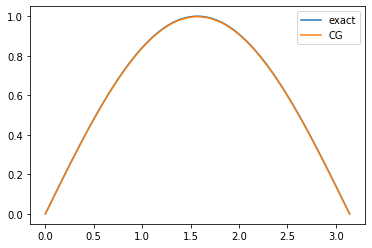

In [54]:
x = np.linspace( omega[ 0 ], omega[ -1 ], len(A) )
ex = np.sin( x )

P = np.diag( np.diag(A) ) 
its_errmax = [ 0, 0 ]
u = conjugate_gradient( A, b, P, its_errmax=its_errmax)

(its, err) = its_errmax
print( f'iterations: {its}' )
print( f'error: {err}' )
print()

plt.plot( x, ex, label = 'exact' )
plt.plot( x, u, label = 'CG' )
plt.legend()

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [65]:
def forward_euler2(omegax, omegat, bc, y0, h, n, f):
    assert h > 0 and n > 0

    (A, b) = finDif( omegax, f, n, bc )
    times = np.arange( omegat[ 0 ], omegat[ 1 ] + h, h ) 
    
    nsteps = len(times)

    sol = np.zeros( (nsteps, n) )
    Au = np.zeros( (nsteps, n) )
    xs = np.linspace( omegax[ 0 ], omegax[ 1 ], n )

    sol[ 0 ] = y0
    for i in range( 0, nsteps - 1 ):
        Au[ i ] = A.dot( sol[ i ] )   
        sol[ i + 1 ] = sol[ i ] + h * (b * np.cos(times[ i ]) - Au[ i ])
    return sol

def forward_euler(A, b, u0, t0, tf, h, alpha):
    time = np.arange( t0, tf + h, h )      
    sol = np.zeros( (len(time), len(u0)) )  

    # solution at time 0
    sol[ 0 : ] = u0
    for idx in range( 1, len(time) ):
        u_xx = -A.dot( sol[idx - 1] )     
        af = alpha( time[idx - 1]) * b        

        sol[ idx ] = sol[idx - 1] + h*u_xx + h*af
    return (sol, time)

In [79]:
t0 = 0
tf = 6 * np.pi
alpha = lambda x: np.cos( x )

n = 100 
omega = [ 0, np.pi ]  

# inv of max eigenvalue is taken as a step
tol = 1e-5
nmax = 500
x = np.linspace( omega[0], omega[1], n )
eigenmax = power_method( A, np.ones_like(x), tol, n )[ 0 ] 
h = eigenmax**(-1)


u0 = np.sin( x )

(sol, time) = forward_euler(A, b, u0, t0, tf, h, alpha)

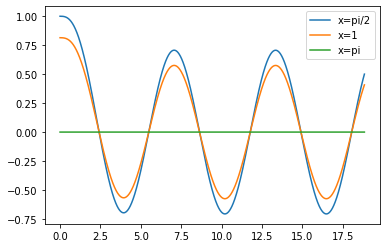

In [80]:
span = omega[ 1 ] - omega[ 0 ]

for (xv, label) in ( (0.5*np.pi, 'x=pi/2'), (1, 'x=1'), (np.pi, 'x=pi') ): 
  idx = int( n / span * xv ) - 1
  plt.plot( time, sol[ :, idx ], label=label )
  plt.legend()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO